# Avoiding Actaeon's Fate - Exploring Utah's Hunting Units

In [1]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import requests
import json
import pprint
import scipy as sc
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 
from scipy.stats import norm
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings('ignore')

## Data Acquisition

In [2]:
# creating full urls from base and tails that do not appear in html of main page (allows us to avoid clicking through to sub-urls)
hunt_code = []
short_url = 'https://dwrapps.utah.gov/huntboundary/HaNumber'
hunt_nums_EB = list(range(3000,3129))  #hard code list of limited entry elk hunt numbers

for each in hunt_nums_EB:
    string_EB = str(each)   # change each hunt number int to str for concatenation purposes
    letters_EB = '?hn=EB' + string_EB   # concatenate hunt letter abbreviations with hunt numbers to create full hunt code
    hunt_code.append(short_url + letters_EB)

# creating empty lists of parameters of interests for later population
hunt_number = []
hunt_type = []
species = []
unit_name = []
weapon_type = []
season_dates = []
percent_harvest = []
pop_obj = []
current_pop = []
age_obj = []
current_age = []

# extracting data from urls
for i in hunt_code:
    res = requests.get(i)
    hunt = json.loads(res.text) 

    ### huntBios key
    res.headers['content-type']
    pagedata = res.content.decode("utf-8")
    hunt_num_json = json.loads(pagedata)
    huntBios = hunt_num_json['huntBios'][0]
    man_obj = huntBios['MANAGEMENT_OBJ']
    split = man_obj.split('~') # relevant information is contained in string; splitting string to useable elements
    # creating perent_harvest, pop_obj, current_pop, age_obj, current_age lists by splitting string correctly
    percent_harvest.append(split[0])
    pop_obj.append(split[1])
    current_pop.append(split[2])
    age_obj.append(split[5])
    current_age.append(split[6])
    

    ### huntMaster key
    # creating unit_name, hunt_number_hunt_type, species, and weapon_type lists from huntMaster key
    huntMaster = hunt_num_json['huntMaster']
    unit_name.append(huntMaster['HUNT_NAME'])
    hunt_number.append(huntMaster['HUNT_NBR'])
    hunt_type.append(huntMaster['HUNT_TYPE'])
    species.append(huntMaster['SPECIES'])
    weapon_type.append(huntMaster['WEAPON'])


    ### huntYears key
    # creating season_dates list from the huntYears key
    huntYears = hunt_num_json['huntYears']
    huntYears0 = (huntYears[0])
    szn = huntYears0['SEASON_DATE_TEXT']
    season_dates.append(szn)

# creating dataframe from lists created in last step
df=pd.DataFrame()
df['Unit_Name']=unit_name
df['Hunt_Number']=hunt_number
df['Type']=hunt_type
df['Species']=species
df['Season_Dates']=season_dates
df['Weapon']=weapon_type
df['Hunter_Success']=percent_harvest
df['Pop_Objective']=pop_obj
df['Current_Pop']=current_pop
df['Age_Objective']=age_obj
df['Current_Age']=current_age



## Data Cleaning
Cleaning our data required programming and manual cleaning. Some strings have extra characters that need to be extracted.  Some string data needs to be converted to int or float types. Also, columns need to be added that account for each hunt's time of year, length of season, and each unit's distance from Salt Lake City.

Several variables from the scraped data required **manual hand cleaning**. The Wasatch Range had populations split among several subregions, so the new data reflects the total population. Certain hunts were missing data, but due to the repetive nature of the data set, we were able to fill in holes using data from other hunts in the same region. In some hunts, letters were added to numerical values match the raw data from other hunts. This was to streamline the automatic cleaning.

This data is saved into a new excel sheet from what was exported during scraping. The new spreadsheet was then loaded back into the notebook and then automatically cleaned. Three processes occured, the first was the removal of the letters from numerical values. The second was the averaging of range esitamtes. These ranges were were split into the upper and lower values then averagred. Finally, all numerical values were converted into floats. 

To obtain data for each hunt's **time of year**, we took the first and last possible days to hunt any season (Aug 17 and January 31). From this data, we found the total hunting year to be 168 days long.  For each hunt, we then took the average day of the hunt and normalized that hunt day over the length of the hunt year. This produced a value from 0 to 1 that corresponded to the hunt season's timing during the overall hunt year.  Small values indicate a hunt season at the very beginning of the hunt year, while larger values indicate a hunt season later in the hunt year. This allowed us to explore how **time of year affects a hunt**. 

To obtain data for **proximity to Salt Lake City**, we took an image of the Utah Hunt Map and analyzed it in NIH's ImageJ software. In ImageJ, we could find coordinates for the center of each hunting unit, as well as coordinates for downtown Salt Lake City. We then used those coordinates to calculate straigh line distance from SLC to the center of the unit.

In [3]:
# manual hand cleaning test

df.head(20)
print(type(df['Pop_Objective'][18]))
print(df['Pop_Objective'][18])
 
df.to_excel('check1.xlsx')

<class 'str'>
5000-5900


In [4]:
# cleaned data in a new dataframe named fd
fd = pd.read_excel(r'check.xlsx', index=False)
#fd.head()

#automatic data cleaning with code
for j in range(0,len(fd)):
    
    #first, get rid of any characters in the population data set (e.i. 1700 (Entire Beaver unit))
    fd['Pop_Objective'][j]= ''.join(i for i in fd['Pop_Objective'][j] if i.isdigit())
    #join to (an empty string) the variable i for every i in (any given variable) if i is a digit
    fd['Pop_Objective'][j] = float(fd['Pop_Objective'][j])
    fd['Current_Pop'][j]= ''.join(i for i in fd['Current_Pop'][j] if i.isdigit())
    #join to (an empty string) the variable i for every i in (any given variable) if i is a digit
    
    #get rid of the ranges of data (i.e. 1200-1500)
    #instead we take the average value of the range (1200-1500 ----> 1350)
    fd['Current_Pop'][j] = float(fd['Current_Pop'][j])
    q = fd['Age_Objective'][j]
    q = q.split('–')
    #idk what that is, but its not a minus sign
    q[0] = float(q[0])
    q[1] = float(q[1])
    fd['Age_Objective'][j] = sum(q)/len(q)

#set the relevant groups to float dtype from objective dtype    
fd[['Pop_Objective','Current_Pop','Age_Objective','Current_Age']]=fd[['Pop_Objective','Current_Pop','Age_Objective','Current_Age']].astype(float)

fd.head(20)

,Unit_Name,Hunt_Number,Type,Species,Season_Dates,Weapon,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length,Dist
0,"Beaver, East",EB3102,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,100.0,1050.0,1450.0,7.75,7.5,0.226190,57,467
1,"Beaver, East",EB3000,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,57.1,1050.0,1450.0,7.75,7.5,0.086310,27,467
2,"Beaver, East",EB3025,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,100.0,1050.0,1450.0,7.75,7.5,0.529762,9,467
3,"Beaver, East",EB3024,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,100.0,1050.0,1450.0,7.75,7.5,0.196429,9,467
4,"Beaver, East",EB3077,Limited Entry,Elk,"Sept 23 - Oct 4, 2019",Muzzleloader,75.0,1050.0,1450.0,7.75,7.5,0.261905,11,467
5,"Book Cliffs, Bitter Creek/South",EB3103,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,85.7,7500.0,6300.0,6.75,7.2,0.226190,57,417
6,"Book Cliffs, Bitter Creek/South",EB3001,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,39.5,7500.0,6300.0,6.75,7.2,0.086310,27,417
7,"Book Cliffs, Bitter Creek/South",EB3027,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,59.5,7500.0,6300.0,6.75,7.2,0.529762,9,417
8,"Book Cliffs, Bitter Creek/South",EB3026,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,81.4,7500.0,6300.0,6.75,7.2,0.196429,9,417
9,"Book Cliffs, Bitter Creek/South",EB3078,Limited Entry,Elk,"Sept 23 - Oct 4, 2019",Muzzleloader,92.0,7500.0,6300.0,6.75,7.2,0.261905,11,417


## Initial Data Exploration

In [3]:
# descriptive statistics on all the numerical elk data
fd.describe()


,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length,Dist
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,70.489922,2848.062016,2646.899225,6.362403,6.279070,0.264027,22.961240,378.953488
std,25.303464,3048.877733,2686.722285,1.017887,1.024441,0.148080,19.117402,149.995045
min,0.000000,140.000000,200.000000,4.750000,4.300000,0.086310,9.000000,77.000000
25%,55.600000,1050.000000,1100.000000,5.750000,5.500000,0.196429,9.000000,268.000000
50%,75.000000,1600.000000,1500.000000,6.750000,6.200000,0.226190,11.000000,384.000000
75%,91.700000,2500.000000,2600.000000,6.750000,7.200000,0.261905,27.000000,485.000000
max,100.000000,12000.000000,11300.000000,7.750000,7.900000,0.833333,69.000000,632.000000


In [20]:
# initial correlation study on numerical data

correlation = fd.corr()
correlation

,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length,Dist
Hunter_Success,1.000000,-0.012462,-0.007076,0.150782,0.310422,0.164387,-0.110561,0.072429
Pop_Objective,-0.012462,1.000000,0.992617,-0.094621,0.107762,-0.015558,0.007278,-0.297616
Current_Pop,-0.007076,0.992617,1.000000,-0.106284,0.082660,-0.008430,0.007352,-0.288190
Age_Objective,0.150782,-0.094621,-0.106284,1.000000,0.761597,-0.056358,0.001631,0.317952
Current_Age,0.310422,0.107762,0.082660,0.761597,1.000000,-0.040690,0.003110,0.357761
Szn_Timing,0.164387,-0.015558,-0.008430,-0.056358,-0.040690,1.000000,-0.256690,-0.012148
Szn_Length,-0.110561,0.007278,0.007352,0.001631,0.003110,-0.256690,1.000000,-0.000309
Dist,0.072429,-0.297616,-0.288190,0.317952,0.357761,-0.012148,-0.000309,1.000000


In [5]:
# data sort to intuitively filter for best units if trophy elk hunting is your preference
fd.sort_values(['Current_Pop', 'Current_Age', 'Hunter_Success'], ascending=[False, False, False])


,Unit_Name,Hunt_Number,Type,Species,Season_Dates,Weapon,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length,Dist
34,"Central Mtns, Manti",EB3108,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,100.0,12000.0,11300.0,5.75,6.1,0.238095,69,268
37,"Central Mtns, Manti",EB3126,Limited Entry,Elk,"Oct 5 - Oct 17, 2019",Any Legal Weapon,84.6,12000.0,11300.0,5.75,6.1,0.333333,13,268
38,"Central Mtns, Manti",EB3038,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,83.6,12000.0,11300.0,5.75,6.1,0.196429,9,268
36,"Central Mtns, Manti",EB3039,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,77.6,12000.0,11300.0,5.75,6.1,0.529762,9,268
39,"Central Mtns, Manti",EB3084,Limited Entry,Elk,"Sept 23 - Oct 4, 2019",Muzzleloader,73.0,12000.0,11300.0,5.75,6.1,0.261905,11,268
35,"Central Mtns, Manti",EB3006,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,37.6,12000.0,11300.0,5.75,6.1,0.086310,27,268
117,Wasatch Mtns,EB3124,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,87.5,8403.0,7200.0,5.75,6.6,0.238095,69,148
121,Wasatch Mtns,EB3072,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,76.0,8400.0,7200.0,5.75,6.6,0.196429,9,148
119,Wasatch Mtns,EB3073,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,69.9,8401.0,7200.0,5.75,6.6,0.529762,9,148
120,Wasatch Mtns,EB3127,Limited Entry,Elk,"Oct 5 - Oct 17, 2019",Any Legal Weapon,62.3,8404.0,7200.0,5.75,6.6,0.333333,13,148


### Rank Order Creation
There are several factors that go into what makes a successful hunt, and the definition of a successful hunt is subjective. We wanted to create a way to have a user input what is important to them in a hunt, and have our system output the top units based on those user input. We decided that a rank order system for each of our variables would work. We normalized each column of data and had the user input act as a weight for that category. Our formula would then aggredate the data and output a final score for each hunt.

In the following cell, please rank the importance of each question on a scale from 0-10 (0 being not important, 10 being very important).<br>
---<br>

In [15]:
# prompts that require user input

trophy = int( input("How important is harvesting a large bull elk?: "))
freezer = int( input("How important is harvesting any elk?: "))
arch = int( input("How important is hunting with a bow?: "))
rifle = int( input("How important is hunting with a rifle?: "))
muzzy = int( input("How important is hunting with a muzzleloader?: "))
length = int( input("How important is having a long hunting season?: "))
multi = int( input("How important is the ability to hunt multiple seasons?: "))
early = int( input("How important is hunting earlier in the year?: "))
late = int( input("How important is hunting later in the year?: "))
distance = int( input("How important is hunting unit proximity to Salt Lake City?: "))

How important is harvesting a large bull elk?: 7
How important is harvesting any elk?: 8
How important is hunting with a bow?: 1
How important is hunting with a rifle?: 9
How important is hunting with a muzzleloader?: 1
How important is having a long hunting season?: 5
How important is the ability to hunt multiple seasons?: 5
How important is hunting earlier in the year?: 8
How important is hunting later in the year?: 4
How important is hunting unit proximity to Salt Lake City?: 9


In [16]:

dummy = pd.get_dummies(fd['Weapon'])
weap = pd.concat([fd,dummy],axis=1)
weap

# making a new dataframe that will have the score output based on the user input
scoreFrame = weap[['Unit_Name','Hunt_Number','Archery','Multiseason','Any Legal Weapon','Muzzleloader']]
scoreFrame['normSucc'] = fd['Hunter_Success']/ fd['Hunter_Success'].max()
scoreFrame['normLength'] = fd['Szn_Length']/ fd['Szn_Length'].max()
scoreFrame['normTime'] = fd['Szn_Timing']/ fd['Szn_Timing'].max()
scoreFrame['normDist'] = fd['Dist']/ fd['Dist'].max()
scoreFrame['normAge'] = fd['Current_Age']/ fd['Current_Age'].max()

scoreFrame['unitScore'] = scoreFrame['normSucc']*freezer +(1-scoreFrame['normTime'])*time +scoreFrame['normAge']*trophy +scoreFrame['Archery']*arch +scoreFrame['Muzzleloader']*muzzy +scoreFrame['Any Legal Weapon']*rifle +scoreFrame['normLength']*length +scoreFrame['Multiseason']*multi +(1-scoreFrame['normDist'])*distance
scoreFrame = scoreFrame.sort_values('unitScore')
scoreFrame = scoreFrame.set_index('Unit_Name')

In [17]:
# exploring the correlation with normalized data
scoreFrame.corr()


,Archery,Multiseason,Any Legal Weapon,Muzzleloader,normSucc,normLength,normTime,normDist,normAge,unitScore
Archery,1.000000,-0.234404,-0.412170,-0.234404,-0.541502,0.101396,-0.576017,0.008815,0.017614,-0.575985
Multiseason,-0.234404,1.000000,-0.422687,-0.240385,0.136671,0.908297,-0.119434,0.004484,0.002369,0.292922
Any Legal Weapon,-0.412170,-0.422687,1.000000,-0.422687,0.228889,-0.557968,0.532210,-0.014104,-0.017647,0.585134
Muzzleloader,-0.234404,-0.240385,-0.422687,1.000000,0.110061,-0.310017,0.020644,0.004484,0.002369,-0.457959
normSucc,-0.541502,0.136671,0.228889,0.110061,1.000000,-0.110561,0.164387,0.072429,0.310422,0.622165
normLength,0.101396,0.908297,-0.557968,-0.310017,-0.110561,1.000000,-0.256690,-0.000309,0.003110,0.087680
normTime,-0.576017,-0.119434,0.532210,0.020644,0.164387,-0.256690,1.000000,-0.012148,-0.040690,0.344299
normDist,0.008815,0.004484,-0.014104,0.004484,0.072429,-0.000309,-0.012148,1.000000,0.357761,-0.344111
normAge,0.017614,0.002369,-0.017647,0.002369,0.310422,0.003110,-0.040690,0.357761,1.000000,0.144161
unitScore,-0.575985,0.292922,0.585134,-0.457959,0.622165,0.087680,0.344299,-0.344111,0.144161,1.000000


## Visualization

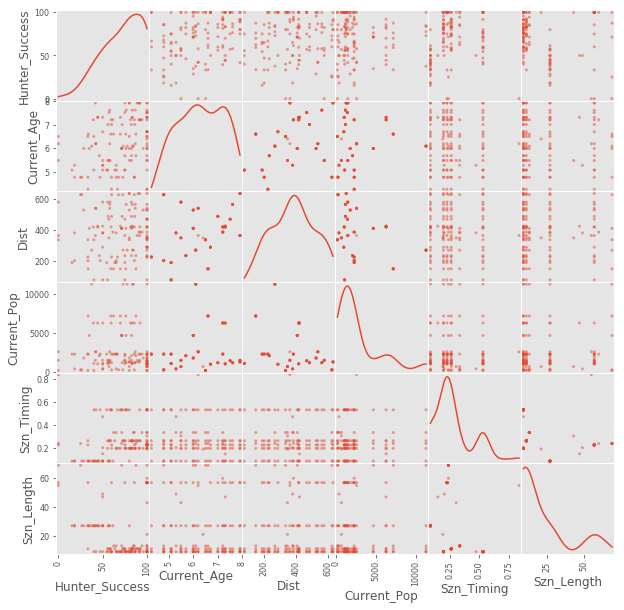

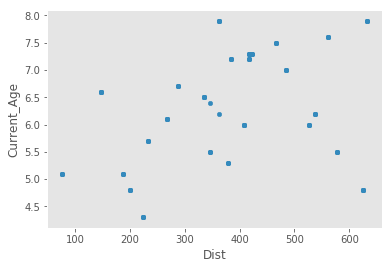

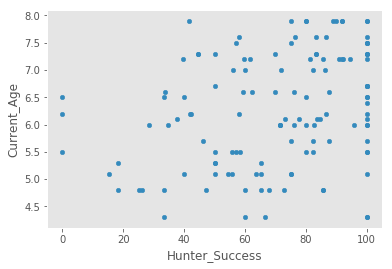

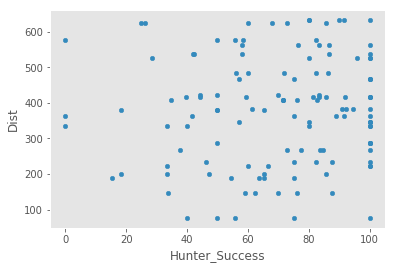

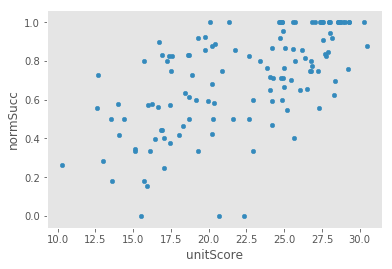

In [30]:
scatter_matrix(weap[['Hunter_Success','Current_Age','Dist','Current_Pop','Szn_Timing','Szn_Length']], figsize=(10,10),diagonal='kde')
weap.plot.scatter('Dist','Current_Age')
weap.plot.scatter('Hunter_Success','Current_Age')
weap.plot.scatter('Hunter_Success','Dist')

scoreFrame.plot.scatter('unitScore','normSucc')

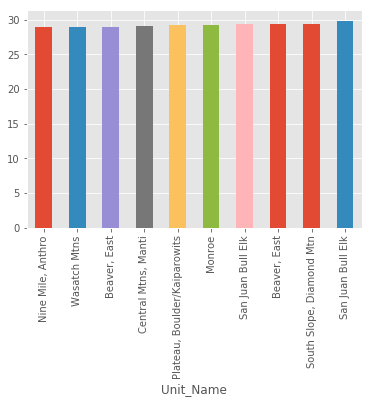

In [13]:
scoreFrame['unitScore'][-11:-1].plot(kind='bar')

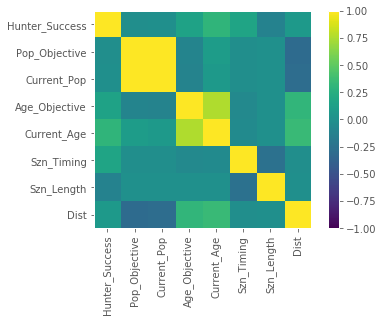

In [24]:
# visualize correlations as matrix

heatmap = plt.imshow(correlation,vmin=-1,vmax=1)
plt.colorbar(heatmap)
plt.xticks(np.arange(8),('Hunter_Success', 'Pop_Objective','Current_Pop','Age_Objective','Current_Age', 'Szn_Timing', 'Szn_Length','Dist'),rotation='vertical')
plt.yticks(np.arange(8),('Hunter_Success', 'Pop_Objective','Current_Pop','Age_Objective','Current_Age', 'Szn_Timing', 'Szn_Length','Dist'),rotation='horizontal')
plt.rcParams["axes.grid"] = False

## Regression Analysis

In [29]:
# Regression on hunt success versus animal population

success =  sm.ols(formula = 'Hunter_Success ~ Current_Pop', data=fd).fit()
success.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Hunter_Success   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                  0.006359
Date:                Sun, 21 Apr 2019   Prob (F-statistic):              0.937
Time:                        14:26:26   Log-Likelihood:                -599.33
No. Observations:                 129   AIC:                             1203.
Df Residuals:                     127   BIC:                             1208.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      70.6663      3.146     22.465      0.000      64.442      76.891
Current_Pop -6.664e-05      0.001     -0.080      0.937      -0.002       0.002
==============================================================================
Omnibus:                       10.591   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.581
Skew:                          -0.732   Prob(JB):                      0.00306
Kurtosis:                       2.903   Cond. No.                     5.29e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# Regression on hunt success

success =  sm.ols(formula = 'Hunter_Success ~ Pop_Objective + Current_Pop + Age_Objective + Current_Age + Szn_Timing + Szn_Length', data=fd).fit()
success.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Hunter_Success   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     4.112
Date:                Sun, 21 Apr 2019   Prob (F-statistic):           0.000855
Time:                        14:35:22   Log-Likelihood:                -587.45
No. Observations:                 129   AIC:                             1189.
Df Residuals:                     122   BIC:                             1209.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        22.5609     15.522      1.453      0.149      -8.167      53.289
Pop_Objective    -0.0088      0.006     -1.504      0.135      -0.020       0.003
Current_Pop       0.0092      0.007      1.393      0.166      -0.004       0.022
Age_Objective    -6.1623      3.311     -1.861      0.065     -12.717       0.392
Current_Age      13.3091      3.342      3.982      0.000       6.693      19.925
Szn_Timing       24.7924     14.651      1.692      0.093      -4.211      53.795
Szn_Length       -0.0980      0.113     -0.867      0.388      -0.322       0.126
==============================================================================
Omnibus:                       10.029   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.219
Skew:                          -0.593   Prob(JB):                      0.00604
Kurtosis:                       3.703   Cond. No.                     4.71e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""